<a href="https://colab.research.google.com/github/aminmh/ml/blob/main/Transfer%20Learning%20with%20VGG16%20(dogs_vs_cats).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle

In [2]:
!mv kaggle.json ~/.kaggle

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c dogs-vs-cats

 99% 805M/812M [00:00<00:00, 1.68GB/s]
100% 812M/812M [00:00<00:00, 1.68GB/s]


In [5]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [6]:
!unzip -qq train.zip

In [7]:
!ls train | wc -l

25000


In [8]:
import os
import shutil
from glob import glob

In [9]:
!rm -r dogs-vs-cats.zip sampleSubmission.csv test1.zip train.zip sample_data/

In [10]:
import tensorflow.keras as keras

In [11]:
from pathlib import Path

In [12]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/content/train'
batch_size = 32
IMAGE_SIZE = (180, 180)

In [13]:
files_lengh = len(glob(original_dataset_dir+'/*.jpg'))

In [14]:
# Directory with our training cat pictures
train_cats_dir = os.path.join(original_dataset_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(original_dataset_dir, 'dogs')
os.mkdir(train_dogs_dir)

In [15]:
# Copy first 1000 cat images to train_cats_dir
fnames = list(glob(original_dataset_dir + '/cat*.jpg'))
for fname in fnames:
    shutil.copyfile(fname, train_cats_dir + '/' + fname.split('/')[-1])

In [16]:
fnames = list(glob(original_dataset_dir + '/dog*.jpg'))
for fname in fnames:
    shutil.copyfile(fname, train_dogs_dir + '/' + fname.split('/')[-1])

In [17]:
for file in list(glob(original_dataset_dir + '/*.jpg')):
  os.remove(file)

In [18]:
print (f"cat images: {len(glob(train_cats_dir + '/cat*.jpg'))}")
print (f"dog images: {len(glob(train_dogs_dir + '/dog*.jpg'))}")

cat images: 12500
dog images: 12500


In [19]:
train_dataset = keras.utils.image_dataset_from_directory(
    Path(original_dataset_dir),
    validation_split=0.2,
    seed=42,
    subset="training",
    image_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [20]:
validation_dataset = keras.utils.image_dataset_from_directory(
    Path(original_dataset_dir),
    validation_split=0.2,
    seed=42,
    subset="validation",
    image_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [21]:
import tensorflow as tf

In [22]:
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batches // 5)
validation_dataset = validation_dataset.skip(validation_batches // 5)

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [56]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip()
    #keras.layers.RandomRotation(0.2),
    #keras.layers.RandomZoom(0.2),
])

In [25]:
rescale = keras.layers.Rescaling(1./255)

In [86]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)
vgg_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SHAPE,
)

In [87]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = vgg_model(image_batch)

In [88]:
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [89]:
global_avg_pooling = keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_pooling(feature_batch)
feature_batch_avg.shape

TensorShape([32, 512])

In [90]:
from keras.applications.vgg16 import preprocess_input

In [91]:
prediction_layer = keras.layers.Dense(1)
inputs = keras.Input(shape=IMAGE_SHAPE)

In [92]:
len(vgg_model.layers)

19

In [93]:
vgg_model.trainable = True

In [94]:
# @title
for layer in vgg_model.layers[:15]:
  layer.trainable = False

In [95]:
x = data_augmentation(inputs)
x = preprocess_input(x)
x = vgg_model(x)
x = global_avg_pooling(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

In [96]:
len(model.trainable_variables)

8

In [97]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 180, 180,  │          0 │ input_layer_11[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 180, 180)  │          0 │ sequential_1[3][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, 180, 180)  │          0 │ sequential_1[3][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_17         │ (None, 180, 180)  │          0 │ sequential_1[3][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_5 (Stack)     │ (None, 180, 180,  │          0 │ get_item_15[0][0… │
│                     │ 3)                │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_17[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 180, 180,  │          0 │ stack_5[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        513 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 7,079,937 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [98]:
from keras import optimizers

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(threshold=0.0)]
)

In [99]:
history = model.fit(
      train_dataset,
      epochs=20,
      validation_data=validation_dataset
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - binary_accuracy: 0.9015 - loss: 0.3325 - val_binary_accuracy: 0.9691 - val_loss: 0.0790
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - binary_accuracy: 0.9660 - loss: 0.0941 - val_binary_accuracy: 0.9773 - val_loss: 0.0633
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - binary_accuracy: 0.9744 - loss: 0.0716 - val_binary_accuracy: 0.9701 - val_loss: 0.0815
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - binary_accuracy: 0.9818 - loss: 0.0518 - val_binary_accuracy: 0.9815 - val_loss: 0.0471
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - binary_accuracy: 0.9829 - loss: 0.0481 - val_binary_accuracy: 0.9800 - val_loss: 0.0526
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - binary_accuracy: 0.9851 - loss: 0.0432 - val_binary_accuracy: 0.9803 - val_loss: 0.0554
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - binary_accuracy: 0.9889 - loss: 0.0340 - val_binary_accuracy: 0.9785 - val_loss:

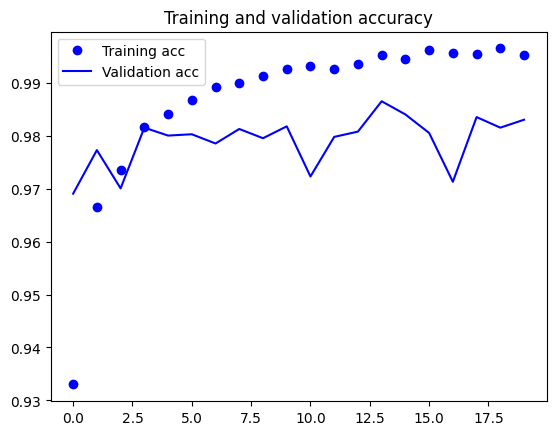

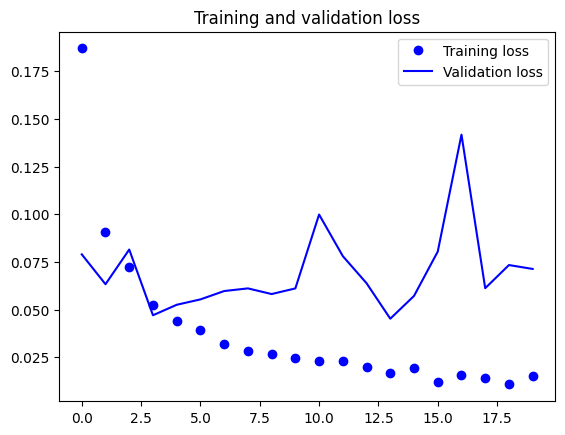

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()